In [1]:
# import packages
import numpy as np
import jax.scipy as jsp # boost computation
import matplotlib.pyplot as plt
import imageio
from os import listdir

In [57]:
# interactive plotting
#%matplotlib notebook
%matplotlib inline

In [ ]:
! tar -xvf /content/AMATH584/HW2/yalefaces_uncropped.tar

In [ ]:
! unzip /content/AMATH584/HW2/yalefaces_cropped.zip

In [27]:
def imread_batch(folder, mode = 'Stack', fname_spec = None):
    '''
    Batch import static images, 2 modes available.
    Input:
        folder: (String) directory name
        mode: 'Stack' or 'Avg'
            'Stack': Stack images of each face as a matrix
            'Avg': Take average of images of each face as a column vector
        fname_spec: (String) specify what is contained in filename
    Output:
        return a 2d numpy matrix with reshaped images as column vectors
    '''
    
    # sanity check on mode
    if (mode != 'Stack') and (mode != 'Avg'):
        print('Error: incorrect mode. Choose between "Stack" or "Avg". ')
        return
    
    # sanity check on folder name
    if folder.endswith('/') == False:
        folder = folder + '/'
    
    # fetch a list of filenames
    if fname_spec == None:
        # assume all files in folder are images
        fnames = sorted(listdir(folder))
    else:
        fnames = list(fname for fname in sorted(listdir(folder)) if fname_spec in fname)
        if len(fnames) == 0:
            print('Error: No file name contains ' + str(fname_spec))
            return

    # determine the dimensions of each image
    temp = imageio.imread(folder + fnames[0])
    idx = temp.shape
    img_num = len(fnames)
  
    # initialize
    img_temp = np.zeros((idx[0]*idx[1], img_num))
    for i in range(img_num):
        # assume the image is in grayscale
        img = imageio.imread(folder + fnames[i])
        img = img.reshape(idx[0]*idx[1])
        img_temp[:,i] = img
    
    # Average mode
    if mode == 'Avg':
        img_data = np.zeros((idx[0]*idx[1], 1))
        img_data[:,0] = img_temp.mean(axis = 1)
    # Stack mode
    elif mode == 'Stack':
        img_data = img_temp
    
    return img_data    

In [30]:
def imread_batch_multidir(folder, mode = 'Stack', fname_spec = None, dirname_spec = None):
    '''
    Batch import static images from multiple directories in folder, 2 modes available.
    Input:
        folder: (String) directory name
        mode: 'Stack' or 'Avg'
            'Stack': Stack images of each face as a matrix
            'Avg': Take average of images of each face as a column vector
        fname_spec: (String) specify what is contained in filename
        dirname_spec: (String) specify what is contained in directory name
    Output:
        return a 2d numpy matrix with reshaped images as column vectors
    '''
    
    # sanity check on mode
    if (mode != 'Stack') and (mode != 'Avg'):
        print('Error: incorrect mode. Choose between "Stack" or "Avg". ')
        return
    
    # sanity check on folder name
    if folder.endswith('/') == False:
        folder = folder + '/'
    
    # fetch a list of directory names
    if dirname_spec == None:
        # assume all items in folder are directories
        dirnames = sorted(listdir(folder))
    else:
        dirnames = list(dirname for dirname in sorted(listdir(folder)) if dirname_spec in dirname)
        if len(dirnames) == 0:
            print('Error: No directory name contains ' + str(dirname_spec))
            return
    
    # avoid ambiguity when passing arguments
    str1, str2 = mode, fname_spec
    
    # Batch import images in each folder
    img_data = imread_batch(folder + dirnames[0], mode = str1, fname_spec = str2)
    for i in range(1, len(dirnames)):
        data = imread_batch(folder + dirnames[i], mode = str1, fname_spec = str2)
        img_data = np.concatenate((img_data, data), axis = 1)
    
    return img_data

In [32]:
img_crop = imread_batch_multidir('CroppedYale/', mode = 'Stack', dirname_spec = 'yale')

In [37]:
img_crop.shape

(32256, 2432)

In [38]:
%%time
u_crop_fast, s_crop_fast, vh_crop_fast = jsp.linalg.svd(img_crop, full_matrices = False)

/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


CPU times: user 2.16 s, sys: 45.3 ms, total: 2.2 s
Wall time: 2.83 s


In [40]:
print(u_crop_fast.shape)
print(s_crop_fast.shape)
print(vh_crop_fast.shape)

(32256, 2432)
(2432,)
(2432, 2432)


In [42]:
%%time
u_crop = np.asarray(u_crop_fast)
s_crop = np.asarray(s_crop_fast)
vh_crop = np.asarray(vh_crop_fast)

CPU times: user 606 µs, sys: 1.98 ms, total: 2.59 ms
Wall time: 2.55 ms


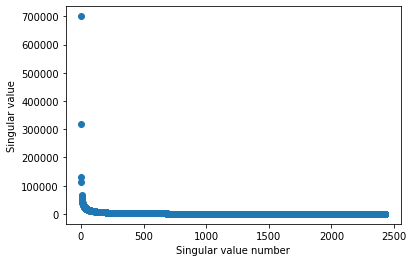

In [64]:
# plot singular values on eigenfaces
plt.figure(1, figsize = (6,4))
#plt.subplot(1,2,1)
plt.scatter(np.arange(1,len(s_crop)+1), s_crop)
plt.xlabel('Singular value number')
plt.ylabel('Singular value')
#plt.subplot(1,2,2)
#plt.semilogy(s_crop)
#plt.xlabel('Singular value number')
#plt.ylabel('Singular value')
plt.show()

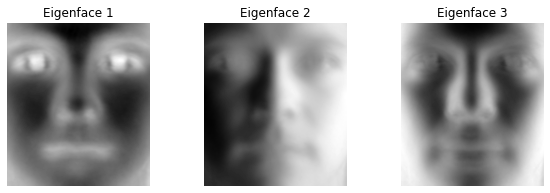

In [65]:
# plot eigenfaces
plt.figure(2, figsize = (10,3))
plt.subplot(1,3,1)
plt.imshow((u_crop[:,0]).reshape(192, 168), cmap = plt.get_cmap("gray"))
plt.title('Eigenface 1')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow((u_crop[:,1]).reshape(192, 168), cmap = plt.get_cmap("gray"))
plt.title('Eigenface 2')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow((u_crop[:,2]).reshape(192, 168), cmap = plt.get_cmap("gray"))
plt.title('Eigenface 3')
plt.axis('off')
plt.show()

In [66]:
def face_reconstruct(u, s, vh, face_no, faces_num = 64, rank = 10, reshape = False, dims = [192, 168], mode = 'Avg'):
    '''
    Reconstruct a specified face by low rank approximation out of SVD
    Input:
        u, s, vh: svd of original faces
        face_no: specify which face to reconstruct
        faces_num: number of images based on the specified face
        rank: number of modes used to reconstruct
        reshape: whether to reshape the vector to a matrix for image
        dims: (list) [length pixels, width pixels]
        mode: 'Avg' or 'Single'
    Output:
        return a vector/reshaped matrix of face
    '''
    
    ur = u[:,0:rank]
    sr = np.diag(s[0:rank])
    vhr = vh[0:rank, faces_num*(face_no-1):faces_num*face_no]
    faces_approx = np.linalg.multi_dot([ur, sr, vhr])
    if mode == 'Single':
        face_approx = faces_approx[:,0]
    else: # average
        face_approx = faces_approx.mean(axis = 1)
    
    if reshape == True:
        face_approx = face_approx.reshape(dims[0], dims[1])
    
    return face_approx

In [67]:
def face_reconstruct_plot(u, s, vh, face_no, dir_origin, faces_amount = 64, rank_list = [10, 20, 50, 100, 200], fname_spec = None, dims = [192, 168]):
    '''
    Plot original face & reconstructed faces by low rank approximation
    Input:
        u, s, vh: svd of original faces
        face_no: specify which face to reconstruct
        dir_origin: (String) location of original face
        faces_amount: amount of images for each face
        rank_list: (list) list of rank used
        fname_spec: (String) specify what is contained in filename
        dims: (list) [length pixels, width pixels]
    Output:
        plot images
        return nothing
    '''
    
    # fetch the data of original face
    if fname_spec: 
        str1 = fname_spec # avoid ambiguous
        face_origin = imread_batch(dir_origin, mode = 'Avg', fname_spec = str1)
    else:
        face_origin = imread_batch(dir_origin, mode = 'Avg')
    face_origin = face_origin.reshape(dims[0], dims[1])
    
    # plot original
    plt.figure(figsize = (10,6))
    plt.subplot(2,3,1)
    plt.imshow(face_origin, cmap = plt.get_cmap("gray"))
    plt.title('Original face')
    plt.axis('off')
    
    for i in range(len(rank_list)):
        
        # compute reconstructed face
        face_approx = face_reconstruct(u, s, vh, face_no, faces_num = faces_amount, rank = rank_list[i], reshape = True, dims = dims)
        # plot reconstructed face
        plt.subplot(2,3,i+2)
        plt.imshow(face_approx, cmap = plt.get_cmap("gray"))
        plt.title('rank = %d' % rank_list[i])
        plt.axis('off')
        
    plt.show()
    
    return

In [68]:
def face_reconstruct_plot_s(u, s, vh, face_no, dir_origin, faces_amount = 64, rank = 200, fname_spec = None, dims = [192, 168]):
    '''
    Plot original face & reconstructed faces by low rank approximation (simple, only 1 rank)
    Input:
        u, s, vh: svd of original faces
        face_no: specify which face to reconstruct
        dir_origin: (String) location of original face
        faces_amount: amount of images for each face
        fname_spec: (String) specify what is contained in filename
        dims: (list) [length pixels, width pixels]
    Output:
        plot images
        return nothing
    '''
    
    # fetch the data of original face
    if fname_spec: 
        str1 = fname_spec # avoid ambiguous
        face_origin = imread_batch(dir_origin, mode = 'Stack', fname_spec = str1)
        face_origin = face_origin[:,0]
    else:
        face_origin = imread_batch(dir_origin, mode = 'Avg')
    face_origin = face_origin.reshape(dims[0], dims[1])
    
    # compute reconstructed face for first expression
    face_approx_s = face_reconstruct(u, s, vh, face_no, faces_num = faces_amount, rank = rank, reshape = True, dims = dims, mode = 'Single')
    # compute reconstructed face averaged over expressions
    face_approx_a = face_reconstruct(u, s, vh, face_no, faces_num = faces_amount, rank = rank, reshape = True, dims = dims, mode = 'Avg')
    
    # plot original
    plt.figure(figsize = (10,3))
    plt.subplot(1,3,1)
    plt.imshow(face_origin, cmap = plt.get_cmap("gray"))
    plt.title('Original face')
    plt.axis('off')
    
    # plot reconstructed face
    plt.subplot(1,3,2)
    plt.imshow(face_approx_s, cmap = plt.get_cmap("gray"))
    plt.title('First expression, rank = %d' % rank)
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow(face_approx_a, cmap = plt.get_cmap("gray"))
    plt.title('Averaged expressions, rank = %d' % rank)
    plt.axis('off')
        
    plt.show()
    
    return

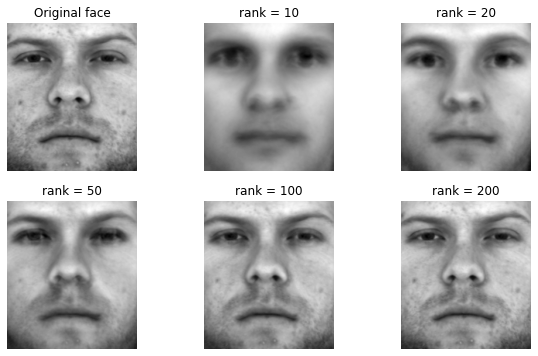

In [69]:
# plot reconstructed faces versus the original
face_reconstruct_plot(u_crop, s_crop, vh_crop, 1, 'CroppedYale/yaleB01', rank_list = [10, 20, 50, 100, 200])

**Uncorpped images **

In [70]:
img_uncrop = imread_batch('yalefaces/')

In [71]:
%%time
u_uncrop_fast, s_uncrop_fast, vh_uncrop_fast = jsp.linalg.svd(img_uncrop, full_matrices = False)

CPU times: user 137 ms, sys: 49 ms, total: 186 ms
Wall time: 183 ms


In [72]:
%%time
u_uncrop = np.asarray(u_uncrop_fast)
s_uncrop = np.asarray(s_uncrop_fast)
vh_uncrop = np.asarray(vh_uncrop_fast)

CPU times: user 773 µs, sys: 0 ns, total: 773 µs
Wall time: 788 µs


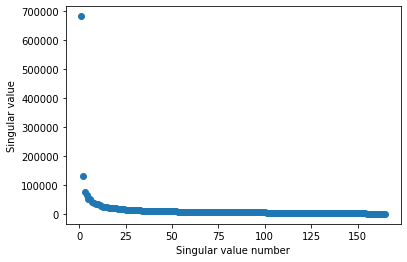

In [73]:
# plot singular values on eigenfaces
plt.figure(11, figsize = (6,4))
#plt.subplot(1,2,1)
plt.scatter(np.arange(1,len(s_uncrop)+1), s_uncrop)
plt.xlabel('Singular value number')
plt.ylabel('Singular value')
#plt.subplot(1,2,2)
#plt.semilogy(s_uncrop)
#plt.xlabel('Singular value number')
#plt.ylabel('Singular value')
plt.show()

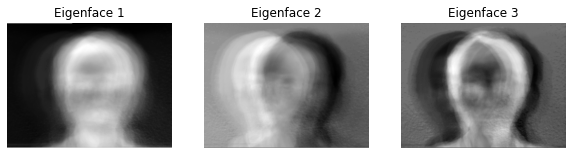

In [75]:
# plot eigenfaces
plt.figure(12, figsize = (10,3))
plt.subplot(1,3,1)
plt.imshow((u_uncrop[:,0]).reshape(243, 320), cmap = plt.get_cmap("gray"))
plt.title('Eigenface 1')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow((u_uncrop[:,1]).reshape(243, 320), cmap = plt.get_cmap("gray"))
plt.title('Eigenface 2')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow((u_uncrop[:,2]).reshape(243, 320), cmap = plt.get_cmap("gray"))
plt.title('Eigenface 3')
plt.axis('off')
plt.show()

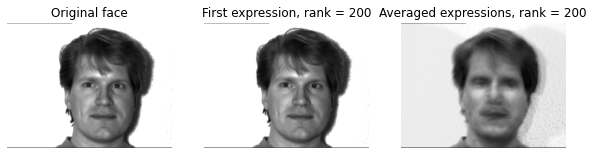

In [77]:
# plot reconstructed faces versus the original
face_reconstruct_plot_s(u_uncrop, s_uncrop, vh_uncrop, 1, 'yalefaces/', faces_amount = 11\
                      , fname_spec = 'subject01', dims = [243, 320])

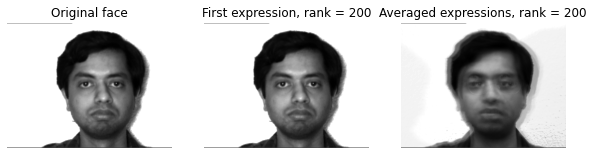

In [78]:
# plot reconstructed faces versus the original
face_reconstruct_plot_s(u_uncrop, s_uncrop, vh_uncrop, 10, 'yalefaces/', faces_amount = 11\
                      , fname_spec = 'subject10', dims = [243, 320])

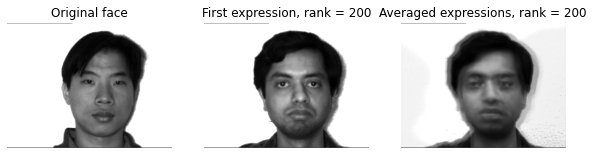

In [79]:
# plot reconstructed faces versus the original
face_reconstruct_plot_s(u_uncrop, s_uncrop, vh_uncrop, 10, 'yalefaces/', faces_amount = 11\
                      , fname_spec = 'subject04', dims = [243, 320])